In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
##Model
##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Yearly data/Flats' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

##Bands and indices

df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') ##make sure no other sensors are being used

df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4'])) ##ndvi conditional based on whether sensor is Landsat-5 or 8

df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])

df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

##DAYMET data added - yearly averages
##PC:
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)

dm['ident'] = dm['Latitude']/dm['Longitude']

##Seasonal averages: growing season (defined as between 3/1 and 10/31)
path3 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Growing season' 
all_files3 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files3:
    dm2 = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm2)

dm2 = pd.concat(li, axis=0, ignore_index=True)

dm2['ident'] = dm2['Latitude']/dm2['Longitude']

dm2 = dm2.rename(columns={'dayl': 'sn_dayl', 'prcp': 'sn_prcp', 'srad': 'sn_srad', \
                        'tmax': 'sn_tmax','tmin': 'sn_tmin','vp': 'sn_vp'})

##Loading elevation data
elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Point_elevation/DEM_vals_10m.csv')

elev_10m.rename(columns={'first':'Elevation'}, inplace=True)

## drop rows which have same lat and long and keep latest entry
dfx = elev_10m.drop_duplicates(
  subset = ['Latitude', 'Longitude'],
  keep = 'last').reset_index(drop = True)

dfx = dfx[['Elevation', 'Latitude', 'Longitude']]
dfx['ident'] = dfx['Latitude']/dfx['Longitude']

df['ident'] = df['Latitude']/df['Longitude'] 

##Merging elevation point data with band dataset prior to model development
df0 = pd.merge(df, dfx, on = 'ident')
df0_sn = pd.merge(df0, dm2)
df1 = pd.merge(df0_sn, dm)

df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['prcp'].notna()] ##CAREFUL; added 7/11/22
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here
df1 = df1[(df1['flats'] < 0.1) & (df1['flats'] > -0.1)] ##Increases NRMSE by 0.003, but seems to be a better fit

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']]

yargs=df1['Plant_Biomass'] 

size_x = 0.2
seed = 0
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test - NOT NEEDED IN IMPLEMENTATION?
# # Pipeline example:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

##Can we remove this and use pipeline in the future?
from sklearn.ensemble import RandomForestRegressor
reg_x=RandomForestRegressor(n_estimators=90, random_state = 0) ##Won't let me do 100
# reg_x.fit(xargs_train, yargs_train)
reg_x.fit(xargs, yargs) ##training using all of the data! Splits/k-fold was for model development, not implementation
# predsss=reg_x.predict(xargs_test)
# print('Mean Abs Error:', metrics.mean_absolute_error(yargs_test, predsss))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, predsss)))
# r_square2 = metrics.r2_score(yargs_test, predsss)
# print(r_square2)

Mean Absolute Error: 253.8086762347206
Mean Squared Error: 154016.65092239095
Root Mean Squared Error: 392.449552073118
The r squared is: 0.31052349214199715
testing r2 is: 0.31052349214199715
training r2 is: 0.9170795170468004
NRMSE is: 0.13158320885463232


RandomForestRegressor(n_estimators=90, random_state=0)

In [3]:
##GEE
ee.Initialize()

#Landsat
ga17 = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_016038_20171016')
ga19 = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_017038_20190927')
ga20 = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_016038_20201008') ##Tide and cloud not checked

def maskL5sr(image):
  ## Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = 1 << 3
  cloudsBitMask = 1 << 5

  ##Get the pixel QA band.
  qa = image.select('pixel_qa')

  ##Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
      .And(qa.bitwiseAnd(cloudsBitMask).eq(0))

  ##Return the masked image, scaled to reflectance, without the QA bands.
  return image.updateMask(mask).divide(10000) \
      .select("B[0-9]*") \
      .copyProperties(image, ["system:time_start"])

##Water masking

##Load or import the Hansen et al. forest change dataset.
hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')

##Select the land/water mask.
datamask = hansenImage.select('datamask')

##Create a binary mask.
watermask = datamask.eq(1)

gamasked17 = ee.Image(maskL5sr(ga17)).updateMask(watermask)
gamasked19 = ee.Image(maskL5sr(ga19)).updateMask(watermask)
gamasked20 = ee.Image(maskL5sr(ga20)).updateMask(watermask)

def addFLATS(image):
    flats = ee.Image(0).expression(
        '1-1/(1+2.718281828459045**(-1.57 + 19.97*(RED-NIR)/(RED+NIR) + 68.55*(GREEN-RED)/(GREEN+RED)))', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(flats.rename('flats'))

FLAT17 = addFLATS(gamasked17)
FLAT19 = addFLATS(gamasked19)
FLAT20 = addFLATS(gamasked20)

#Daymet
daymet = ee.ImageCollection('NASA/ORNL/DAYMET_V4') \
     .filter(ee.Filter.date('2019-01-01', '2019-12-31')) \
     .mean()

roi = ee.Geometry.Point([-81.422318, 31.539096]).buffer(1000000)
daymet = daymet.clip(roi)

dm_precip = daymet.select('prcp')
dm_maxtemp = daymet.select('tmax')
dm_mintemp = daymet.select('tmin')
dm_daylight = daymet.select('dayl')
dm_srad = daymet.select('srad')
dm_snow = daymet.select('swe')
dm_vapor = daymet.select('vp')

prcpVis = {
  'min': -40.0,
  'max': 30.0,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

daylVis = {
  'min': 0,
  'max': 50000.0,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

sradVis = {
  'min': 0,
  'max': 400.0,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

vpVis = {
  'min': 0,
  'max': 1500,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

#DEM
dem2 = ee.Image('USGS/3DEP/10m')

dem2 = dem2.select(['elevation'], ['Elevation'])

dem2 = dem2.clip(roi)

dem_params = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}


Map = geemap.Map(center=[40,-100], zoom=4)



Map.addLayer(FLAT19, {'bands': ['B5',  'B4',  'B3'], 'min': 0, 'max': 0.2}, 'Flats 2019')
Map.addLayer(dem2, dem_params, '10m DEM', True, 1)
Map.addLayer(dm_precip, prcpVis, "prcp")
Map.addLayer(dm_maxtemp, prcpVis, "tmax")
Map.addLayer(dm_mintemp, prcpVis, "tmin")
Map.addLayer(dm_daylight, daylVis, "dayl")
Map.addLayer(dm_srad, sradVis, "srad")
Map.addLayer(dm_snow, prcpVis, "swe")
Map.addLayer(dm_vapor, vpVis, "vp")

Map


Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [4]:
##Make all variables included in model ##WATCH OVER-MASKING

from geemap import ml

collection = ee.ImageCollection([daymet, FLAT19, dem2]) ##2019!

collection.getInfo()

img1 = ee.Image([daymet, FLAT19, dem2])

# Map.addLayer(collection, {}, 'collection')

##Land masking using NLCD:
dataset = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD')
nlcd2019 = dataset.filter(ee.Filter.eq('system:index', '2019')).first() ##use different NLCD image for earlier years
landcover = nlcd2019.select('landcover')
elev_set = dem2.select('Elevation')
elevmask = elev_set.updateMask(elev_set.lte(2)) ##Elevation masking - BE CAREFUL HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

landcovermask = landcover.remap([31,95], [1,1]) ##90,11 removed. How to get land represented, just an unrelated color?

img1 = img1.updateMask(landcovermask)
img1 = img1.updateMask(elevmask)

img2 = gamasked19 ##As a background layer?

##Adding variables in LANDSAT 8:

def addsavi(image):
    savi = image.expression(
        '(1.5*(NIR-RED))/(RED+NIR+0.5)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(savi.rename('savi'))

def addwdrvi5(image):
    wdrvi5 = image.expression(
        '(0.5*NIR-RED)/(RED+NIR*0.5)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(wdrvi5.rename('wdrvi5'))

def addnd_r_g(image):
    nd_r_g = image.expression(
        '(RED-GREEN)/(RED+GREEN)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(nd_r_g.rename('nd_r_g'))

def addnd_g_b(image):
    nd_g_b = image.expression(
        '(GREEN-BLUE)/(BLUE+GREEN)', {
            'RED': image.select('B4'),
            'GREEN': image.select('B3'),
            'BLUE': image.select('B2')
        })
    
    return image.addBands(nd_g_b.rename('nd_g_b'))

def addnd_swir2_nir(image):
    nd_swir2_nir = image.expression(
        '(swir2-NIR)/(swir2+NIR)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'swir2': image.select('B7')
        })
    
    return image.addBands(nd_swir2_nir.rename('nd_swir2_nir'))

def addnd_swir2_r(image):
    nd_swir2_r = image.expression(
        '(swir2-RED)/(swir2+RED)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'swir2': image.select('B7')
        })
    
    return image.addBands(nd_swir2_r.rename('nd_swir2_r'))

def addndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

##REMEMBER: THIS IS ONLY LANDSAT 8! WILL NEED TO REDO BANDS FOR LS5 IMAGES
img1 = addsavi(img1)
img1 = addwdrvi5(img1)
img1 = addnd_r_g(img1)
img1 = addnd_g_b(img1)
img1 = addnd_swir2_nir(img1)
img1 = addnd_swir2_r(img1)
img1 = addndvi(img1)

Map.addLayer(img1, {}, 'img1')

feature_names = ['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']

In [5]:
# ##Make all variables included in model ##WATCH OVER-MASKING

# from geemap import ml

# collection = ee.ImageCollection([daymet, FLAT19, dem2]) ##2019!

# collection.getInfo()

# img1 = ee.Image([daymet, FLAT19, dem2])

# # Map.addLayer(collection, {}, 'collection')

# ##Land masking using NLCD:
# dataset = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD')
# nlcd2019 = dataset.filter(ee.Filter.eq('system:index', '2019')).first() ##use different NLCD image for earlier years
# landcover = nlcd2019.select('landcover')
# elev_set = dem2.select('Elevation')
# elevmask = elev_set.updateMask(elev_set.lte(2)) ##Elevation masking - BE CAREFUL HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# landcovermask = landcover.remap([31,95], [1,1]) ##90,11 removed. How to get land represented, just an unrelated color?

# img1 = img1.updateMask(landcovermask)
# img1 = img1.updateMask(elevmask)


##Adding variables in LANDSAT 5:

def L5addsavi(image):
    savi = image.expression(
        '(1.5*(NIR-RED))/(RED+NIR+0.5)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(savi.rename('savi'))

def L5addwdrvi5(image):
    wdrvi5 = image.expression(
        '(0.5*NIR-RED)/(RED+NIR*0.5)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(wdrvi5.rename('wdrvi5'))

def L5addnd_r_g(image):
    nd_r_g = image.expression(
        '(RED-GREEN)/(RED+GREEN)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(nd_r_g.rename('nd_r_g'))

def L5addnd_g_b(image):
    nd_g_b = image.expression(
        '(GREEN-BLUE)/(BLUE+GREEN)', {
            'RED': image.select('B3'),
            'GREEN': image.select('B2'),
            'BLUE': image.select('B1')
        })
    
    return image.addBands(nd_g_b.rename('nd_g_b'))

def L5addnd_swir2_nir(image):
    nd_swir2_nir = image.expression(
        '(swir2-NIR)/(swir2+NIR)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'swir2': image.select('B7')
        })
    
    return image.addBands(nd_swir2_nir.rename('nd_swir2_nir'))

def L5addnd_swir2_r(image):
    nd_swir2_r = image.expression(
        '(swir2-RED)/(swir2+RED)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'swir2': image.select('B7')
        })
    
    return image.addBands(nd_swir2_r.rename('nd_swir2_r'))

def L5addndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

# img1 = addsavi(img1)
# img1 = addwdrvi5(img1)
# img1 = addnd_r_g(img1)
# img1 = addnd_g_b(img1)
# img1 = addnd_swir2_nir(img1)
# img1 = addnd_swir2_r(img1)
# img1 = addndvi(img1)

# Map.addLayer(img1, {}, 'img1')

# feature_names = ['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
#            'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']

In [6]:
##Incorporating ML model into geemap (takes some time)

##Model implementation - can we get 'pipe' in here??
trees = ml.rf_to_strings(reg_x, feature_names, output_mode="REGRESSION")

# print(trees[0])
n_trees = 90
len(trees) == n_trees

# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

classified = img1.select(feature_names).classify(ee_classifier)

# classified = img1.select(feature_names).classify(pipe)

In [7]:
import geemap.colormaps as cm
roi2 = ee.Geometry.Point([-81.2890, 31.3985]).buffer(20000)
palette = cm.palettes.BuGn

Map.addLayer(
    classified.clip(roi2),
    {"min": 0, "max": 1500, 'palette': palette},
    'classification',
)

# Map.add_legend(title='Spartina alterniflora biomass', labels=classified.select('classification'), colors=palette)

Map

# cm.list_colormaps()

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

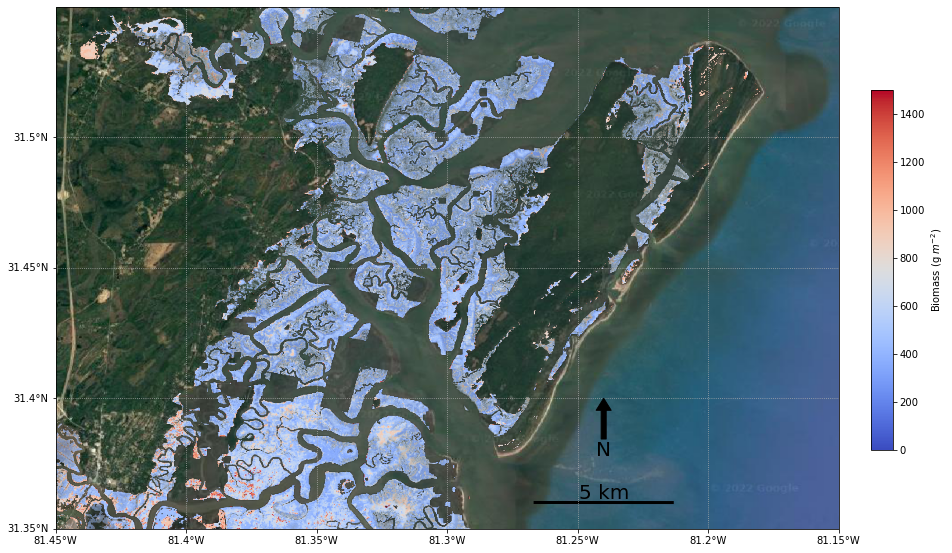

In [8]:
##Cartoee
from geemap import cartoee
import cartopy.io.img_tiles as cimgt

# geospatial region in format [E,S,W,N]
region = [-81.5, 31, -80.75, 32]  # define bounding box to request data
out_region = [180, -60, -180, 85]
zoom_region = [-81.15, 31.35, -81.45, 31.55]
flux_region = [-81.26, 31.42, -81.3, 31.45] ##Why are coordinates changing based on zoom level?? Projection issue?

vis = {'min': 0, 'max': 1500}  # define vis parameters for image

cmap = "coolwarm"

fig = plt.figure(figsize=(15, 10))

basemap = cimgt.Stamen('terrain-background')

# use cartoee to get a map
ax = cartoee.get_map(classified, region=zoom_region, vis_params=vis, cmap = cmap, basemap='SATELLITE', zoom_level=12)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(ax, vis, cmap = cmap, loc="right", label="Biomass (g $m^{-2}$)", orientation="vertical")

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.05, 0.05], linestyle=":")

# add coastlines using the cartopy api - way off! check with zoomed out image
# ax.coastlines(color="red")

# add north arrow
cartoee.add_north_arrow(
    ax, text="N", xy=(0.7, 0.25), text_color="black", arrow_color="black", fontsize=20
)

# add scale bar
cartoee.add_scale_bar_lite(
    ax, length=5, xy=(0.7, 0.05), fontsize=20, color="black", unit="km"
)


# cartoee.add_layer(img2, zorder=0)
##More info here: https://geemap.org/notebooks/50_cartoee_quickstart/#plotting-an-image
##And here: https://geemap.org/notebooks/66_cartoee_legend/
##https://geemap.org/notebooks/112_cartoee_basemap/#use-other-basemaps


In [ ]:
##Note on map (above): block areas of missing data (not cloud-masked regions) are missing daymet data most likely

##Double check elevation masking!! Right now, set to elev < 2 - there might be better ways to mask out land/vegetation

##Also - coordinates do not seem to match up well - projection issues perhaps?

##Landmask is a little awkward - any way to make it a solid color, unrelated to color ramp?